In [60]:
import os
# !pip install unrar
# !unrar x '/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/800_dataset_with_semantic_segmentation.rar'

In [61]:
# from google.colab import drive
# drive.mount('/content/drive')

In [62]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import backend as K

  
import tensorflow as tf
from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras.preprocessing.image import *
from keras.callbacks import *

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [63]:
w, h = 640, 640
border = 5 

In [64]:
ids = next(os.walk("dataset_copy_3_imgs/train/Images"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  3


# **Data Reading and Train test split**

In [65]:
# from google.colab import drive
# drive.mount('/content/drive')

In [66]:
import glob
train = sorted(glob.glob("dataset_copy_3_imgs/train/Images/*"))
train_mask = sorted(glob.glob("dataset_copy_3_imgs/train/Mask/*.jpg"))
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 3
Total Mask Image : 3


In [67]:
X = np.zeros((len(train), h, w, 1), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [68]:
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
  # print(n, img, mimg)
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X[n] = x_img/255.0
  y[n] = mask/255.0

0it [00:00, ?it/s]

In [69]:
# Save the files in Numpy array for reusability
np.save('x_y_npy/x.npy', X)
np.save('x_y_npy/y.npy', y)
print(X.shape, y.shape)
X = np.load('x_y_npy/x.npy')
y = np.load('x_y_npy/y.npy')
print(X.shape, y.shape)

(3, 640, 640, 1) (3, 640, 640, 1)
(3, 640, 640, 1) (3, 640, 640, 1)


In [70]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
gc.collect()

(2, 640, 640, 1) (2, 640, 640, 1) (1, 640, 640, 1) (1, 640, 640, 1)


6800

# **Visualization the image and It masks**

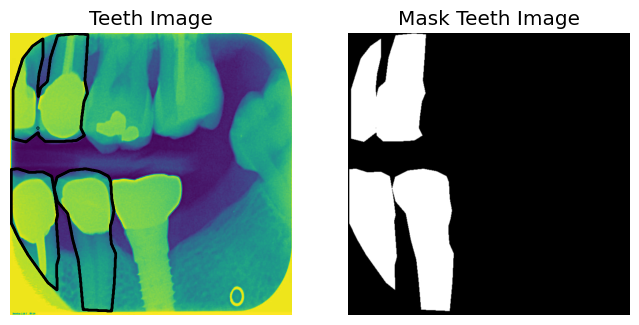

In [71]:
# Visualize any randome image along with the mask
idx = random.randint(0, len(X_train)-1)
has_mask = y_train[idx].max() > 0 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 8))

ax1.imshow(X_train[idx, ..., 0], interpolation = 'bilinear')
if has_mask:
    ax1.contour(y_train[idx].squeeze(), colors = 'k', linewidths = 2, levels = [0.5])
ax1.set_title('Teeth Image')
ax1.set_axis_off() # 不顯示 x, y 軸線

ax2.imshow(y_train[idx].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Teeth Image')
ax2.set_axis_off() # 不顯示 x, y 軸線

### DenseUnet

In [72]:
def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1 = BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


def DenseUNet(image_size=304):

    filters=16
    keep_prob=0.9
    block_size=7

    inputs = Input(shape=(image_size, image_size, 1)) # change 

    conv1 = Conv2D(filters * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    conv1 = DenseBlock(filters * 1, conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = DenseBlock(filters * 2, pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = DenseBlock(filters * 4, pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)

    convm = DenseBlock(filters * 8, pool3)

    deconv3 = Conv2DTranspose(filters * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Conv2D(filters * 4, (1, 1), activation=None, padding="same")(uconv3)
    uconv3 = BatchActivate(uconv3)
    uconv3 = DenseBlock(filters * 4, uconv3)


    deconv2 = Conv2DTranspose(filters * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(filters * 2, (1, 1), activation=None, padding="same")(uconv2)
    uconv2 = BatchActivate(uconv2)
    uconv2 = DenseBlock(filters * 2, uconv2)

    deconv1 = Conv2DTranspose(filters * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(filters * 1, (1, 1), activation=None, padding="same")(uconv1)
    uconv1 = BatchActivate(uconv1)
    uconv1 = DenseBlock(filters * 1, uconv1)

    outputs = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    outputs = Activation('sigmoid')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [73]:
from keras import backend as K
K.clear_session()

# input_img = Input((h, w, 1), name='img')
model = DenseUNet(image_size = 640)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)

In [74]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 640, 640, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 640, 640, 16)         160       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 640, 640, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 640, 640, 16)         0         ['batch_normalization[0][0

In [75]:
# plot_model(model, to_file='model/DenseUnet.png', show_shapes=True, show_layer_names=True)

In [76]:

callbacks = [
    EarlyStopping(patience=15, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=7, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model/model-DenseUnet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("result/data_DenseUnet.csv"),
    TensorBoard(log_dir='./logs')
]
# >> tensorboard --logdir=path/to/logs

In [77]:
results = model.fit(X_train, y_train, batch_size=1, epochs=5, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True, workers=31)

Epoch 1/5
2/2 [==============================] - ETA: 0s - loss: 0.6278 - accuracy: 0.6520 - auc: 0.4989 - sensitivity_at_specificity: 0.4749 - specificity_at_sensitivity: 0.4738 
Epoch 1: val_loss improved from inf to 0.67310, saving model to model\model-DenseUnet.h5
2/2 [==============================] - 45s 7s/step - loss: 0.6278 - accuracy: 0.6520 - auc: 0.4989 - sensitivity_at_specificity: 0.4749 - specificity_at_sensitivity: 0.4738 - val_loss: 0.6731 - val_accuracy: 0.7706 - val_auc: 0.3633 - val_sensitivity_at_specificity: 0.2531 - val_specificity_at_sensitivity: 0.2531 - lr: 0.0010
Epoch 2/5
2/2 [==============================] - ETA: 0s - loss: 0.5574 - accuracy: 0.7430 - auc: 0.6336 - sensitivity_at_specificity: 0.6880 - specificity_at_sensitivity: 0.6835
Epoch 2: val_loss improved from 0.67310 to 0.67102, saving model to model\model-DenseUnet.h5
2/2 [==============================] - 6s 3s/step - loss: 0.5574 - accuracy: 0.7430 - auc: 0.6336 - sensitivity_at_specificity: 0.6

* results 物件

In [78]:
print(results.history)
print(results.epoch)
print(results.model)

{'loss': [0.6277977228164673, 0.5573703646659851, 0.5281089544296265, 0.5012903213500977, 0.481526255607605], 'accuracy': [0.6520446538925171, 0.742950439453125, 0.7586132884025574, 0.7802221775054932, 0.7903967499732971], 'auc': [0.49890953302383423, 0.6336360573768616, 0.6639863848686218, 0.6873841881752014, 0.7060540914535522], 'sensitivity_at_specificity': [0.4749387204647064, 0.6879537105560303, 0.7098614573478699, 0.7303531765937805, 0.7612156867980957], 'specificity_at_sensitivity': [0.4737979471683502, 0.683495819568634, 0.7345653176307678, 0.7629820108413696, 0.7779498100280762], 'val_loss': [0.6730962991714478, 0.6710177659988403, 0.6685693264007568, 0.6647326946258545, 0.6610472202301025], 'val_accuracy': [0.7706005573272705, 0.7706396579742432, 0.7706396579742432, 0.770642101764679, 0.770642101764679], 'val_auc': [0.36330991983413696, 0.3406642973423004, 0.31871455907821655, 0.30856359004974365, 0.29929494857788086], 'val_sensitivity_at_specificity': [0.2531161904335022, 0.

In [79]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,lr
4,0.481526,0.790397,0.706054,0.761216,0.777950,0.661047,0.770642,0.299295,0.143797,0.218546,0.001
3,0.501290,0.780222,0.687384,0.730353,0.762982,0.664733,0.770642,0.308564,0.147565,0.183587,0.001
2,0.528109,0.758613,0.663986,0.709861,0.734565,0.668569,0.770640,0.318715,0.137495,0.255117,0.001
1,0.557370,0.742950,0.633636,0.687954,0.683496,0.671018,0.770640,0.340664,0.255245,0.172448,0.001
0,0.627798,0.652045,0.498910,0.474939,0.473798,0.673096,0.770601,0.363310,0.253116,0.253112,0.001


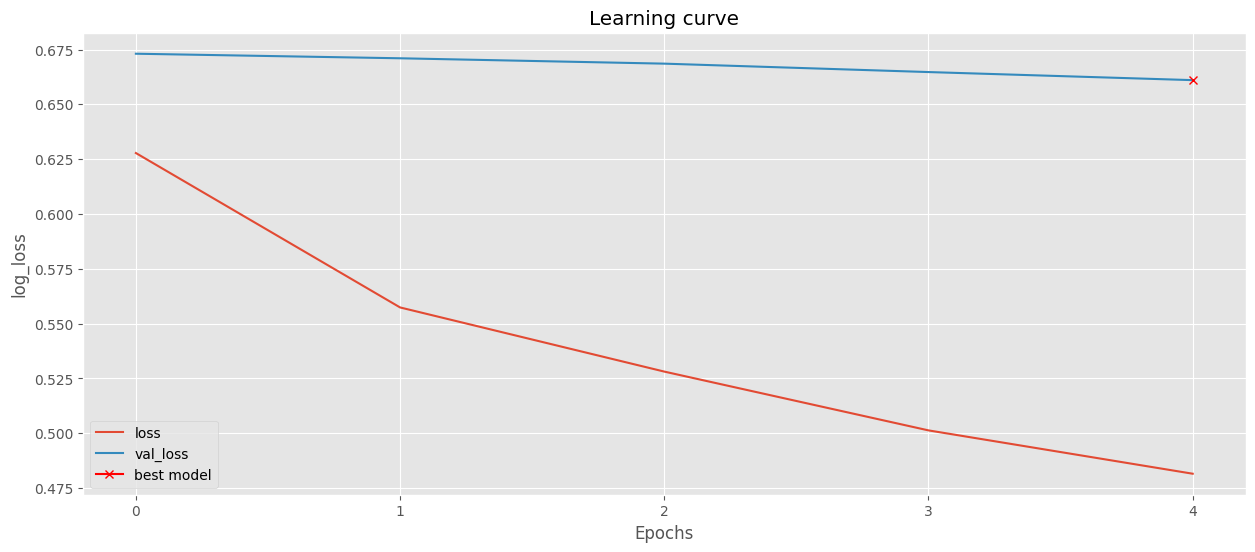

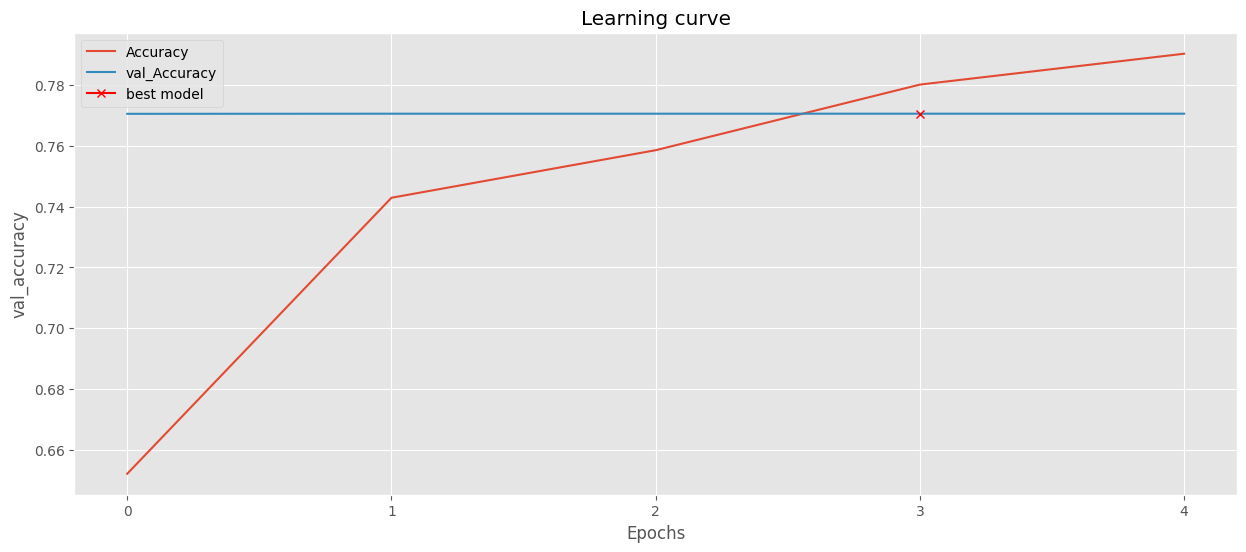

In [80]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss") # 畫出訓練集的損失函數，並標示為 "loss"。
plt.plot(results.history["val_loss"], label="val_loss") # 畫出驗證集的損失函數，並標示為 "val_loss"。

## 在最佳驗證損失處標示一個紅色的 "x"，表示最佳模型的位置。
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.xticks(results.epoch)
plt.legend(); # 在圖中添加圖例
plt.savefig('result/log_loss.png')

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")

plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("val_accuracy")
plt.xticks(results.epoch)
plt.legend(); 
plt.savefig('result/val_accuracy.png')

# **Inference**

In [81]:
model.load_weights('model/model-DenseUnet.h5')

In [82]:
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 3s 3s/step - loss: 0.6610 - accuracy: 0.7706 - auc: 0.2993 - sensitivity_at_specificity: 0.1438 - specificity_at_sensitivity: 0.2185


[0.6610472202301025,
 0.770642101764679,
 0.29929494857788086,
 0.143796905875206,
 0.2185455709695816]

In [83]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

1/1 [==============================] - 1s 626ms/step


In [85]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
print(preds_val.shape)
print(preds_val_t.shape)

(1, 640, 640, 1)
(1, 640, 640, 1)


In [95]:
def plot_sample(X, y, preds, binary_preds, idx=None):
    """Function to plot the results"""
    if idx is None:
        idx = random.randint(0, len(X))

    has_mask = y[idx].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10)) # 建立子圖

    # 顯示原圖
    ax[0].imshow(X[idx, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[idx].squeeze(), colors='k', linewidths=2, levels=[0.5])
    ax[0].set_title('Teeth Image')
    ax[0].set_axis_off()

    # 顯示 mask 照片
    ax[1].imshow(y[idx].squeeze(), cmap='gray')
    ax[1].set_title('Teeth Mask Image')
    ax[1].set_axis_off()

    # 顯示預測到的所有物件
    ax[2].imshow(preds[idx].squeeze(), cmap='gray', vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(preds[idx].squeeze(), colors='pink', levels=[0.5]) # change 
    ax[2].set_title('Teeth Image Predicted')
    ax[2].set_axis_off()
    
    # 顯示預測到的物件信心值高於 50%
    ax[3].imshow(binary_preds[idx].squeeze(), cmap='gray', vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(binary_preds[idx].squeeze(), colors='pink', levels=[0.5]) # change 
    ax[3].set_title('Teeth Mask Image Predicted binary')
    ax[3].set_axis_off()    

# **Predictions on training set**

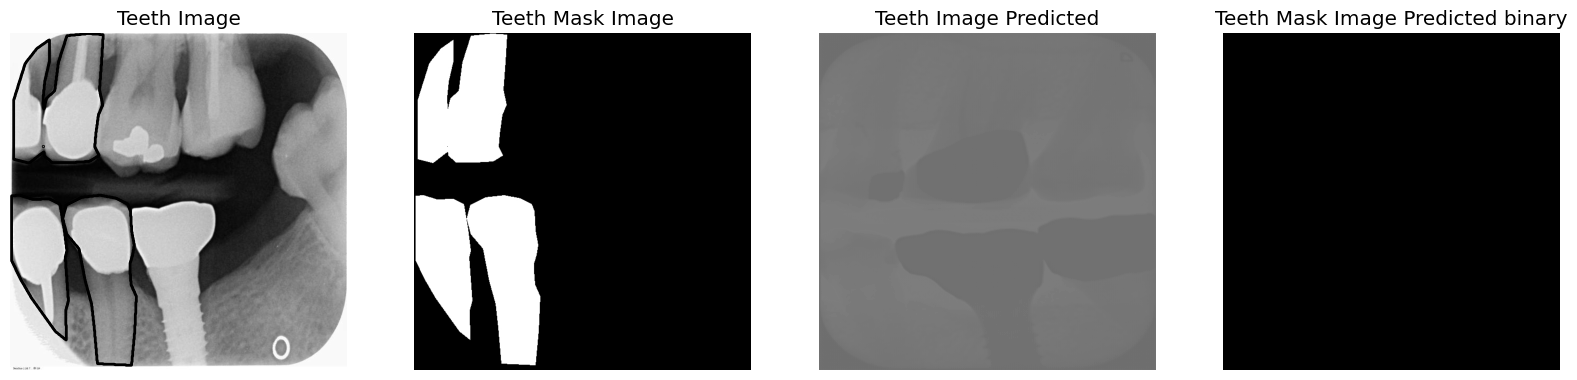

In [96]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_val, preds_val_t, 0)

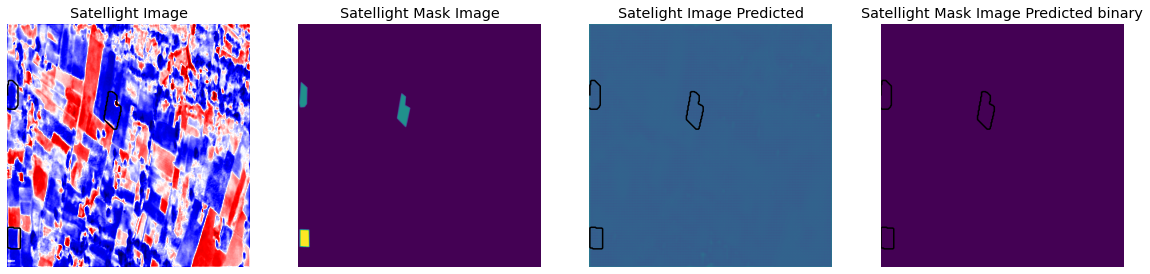

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

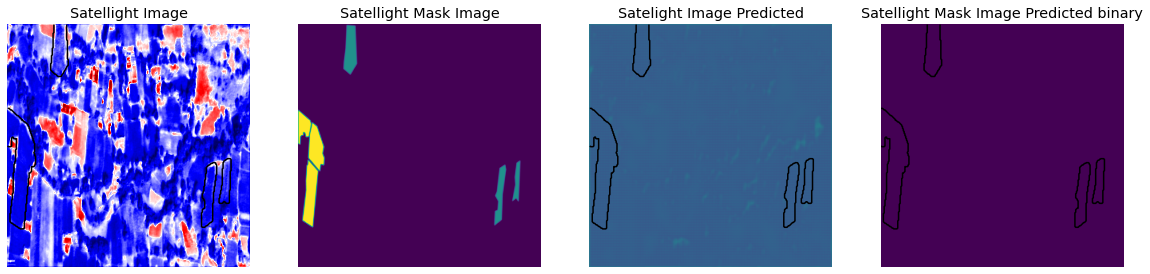

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

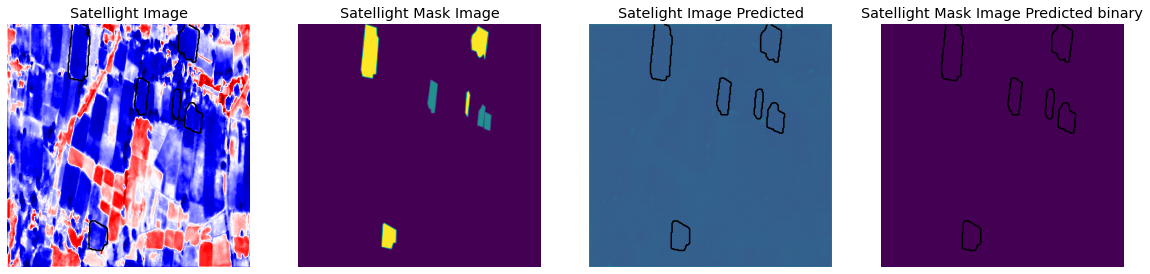

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

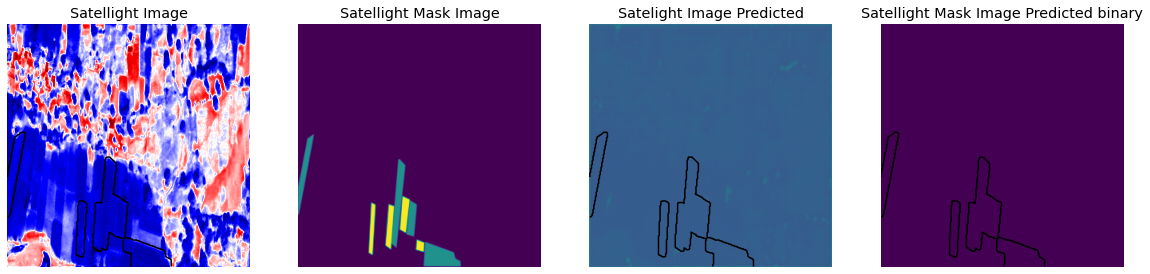

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

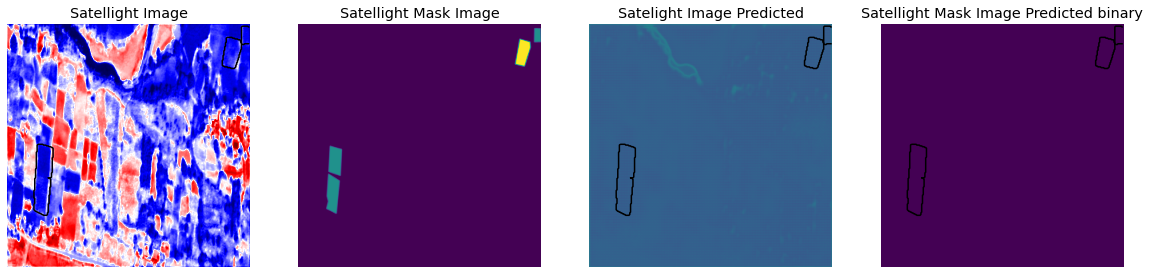

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)